### **Tabel Kontribusi Team 3:**

| Nama                   | NPM        | Kontribusi                                                                   | % Kontribusi |
|:------------------------:|:------------:|:-------------------------------------------------------------------------------:|:--------------:|
| Amira Shohifa | 2206829130 | Terlibat aktif dalam diskusi dan ikut serta dalam mengerjakan keseluruhan bagian. | 100%         |
| Angelia Huwinata          | 2206051595 | Terlibat aktif dalam diskusi dan ikut serta dalam mengerjakan keseluruhan bagian. | 100%         |
| Gregorius Nicholas Manik          | 2206051443 | Terlibat aktif dalam diskusi dan ikut serta dalam mengerjakan keseluruhan bagian. | 100%         |
| Zavier Raiyan Dana         | 2206829875 | Terlibat aktif dalam diskusi dan ikut serta dalam mengerjakan keseluruhan bagian. | 100%         |


### **Predict Disaster Tweets**

**Sumber Data**: [Kaggle - Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data)

Dataset ini berisi tweet yang diklasifikasikan apakah tweet tersebut berkaitan dengan bencana (Disaster) atau tidak. Akan diprediksi apakah sebuah tweet berhubungan dengan bencana atau tidak berdasarkan teks tweet. Berikut adalah deskripsi dari masing-masing variabel:

| Nama Variabel        | Deskripsi                                                                 |
|----------------------|---------------------------------------------------------------------------|
| `id`                 | ID unik untuk setiap tweet                                               |
| `text`               | Teks tweet                                                               |
| `location`           | Lokasi tweet dikirim (bisa kosong)                                        |
| `keyword`            | Kata kunci dari tweet (bisa kosong)                                      |
| `target`             | Label untuk menentukan apakah tweet berkaitan dengan bencana (1) atau tidak (0) |


# Load Dataset

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/amirashhf/NLPData/main/'

train_df = pd.read_csv(url + 'train.csv', delimiter=',')
test_df = pd.read_csv(url + 'test.csv', delimiter=',')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# EDA

In [ ]:
# Melihat informasi umum tentang dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


- Dataset terdiri dari 7613 entri (baris) dan 5 kolom.
- Kolom 'id' tidak memiliki missing values, tetapi kolom ini tidak relevan untuk analisis.
- Kolom 'keyword' memiliki 61 missing values.
- Kolom 'location' memiliki 2533 missing values.
- Kolom 'text' tidak memiliki missing values.
- Kolom 'target' tidak memiliki missing values.

In [ ]:
# Melihat statistik deskriptif untuk kolom numerik (tanpa kolom 'id')
train_df.drop(columns=['id'], axis=1).describe()

,target
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


**Note: Kolom 'id' akan diabaikan karena tidak relevan untuk analisis**
### Kolom 'target'
- count: 7613 entri.
- mean sekitar 0.43, berarti sekitar 43% tweet memiliki label 1 (disaster) dan 57% lainnya memiliki label 0 (non-disaster).
- std sekitar 0.495, berarti variabilitas dalam kolom ini cukup tinggi (antara 0 dan 1).
- min: 0 karena kolom ini hanya berisi dua nilai, yaitu 0 dan 1.
- 25%, 50%: 0 menunjukkan bahwa 25% maupun 50% data bernilai 0.
- 75%: 1 menunjukkan bahwa 75% data bernilai lebih kecil atau sama dengan 1.
- max: 1 karena kolom ini hanya berisi dua nilai, yaitu 0 dan 1.

In [ ]:
# Menghitung panjang kata dan karakter untuk setiap tweet
text_length = train_df['text'].apply(len)

# Menampilkan statistik deskriptif dari panjang karakter
text_length.describe()

,text
count,7613.000000
mean,101.037436
std,33.781325
min,7.000000
25%,78.000000
50%,107.000000
75%,133.000000
max,157.000000


### Kolom 'text_length'
- count: 7613 entri.
- mean sekitar 101.04, berarti rata-rata panjang tweet sekitar 101 karakter.
- std sekitar 33.78 menunjukkan variasi yang signifikan dalam panjang tweet.
- min: 7, berarti tweet yang paling pendek terdiri dari 7 karakter.
- 25%: 78 menunjukkan bahwa 25% tweet memiliki panjang lebih kecil atau sama dengan 78 karakter.
- 50%: 107 menunjukkan bahwa 50% tweet memiliki panjang lebih kecil atau sama dengan 107 karakter.
- 75%: 133 menunjukkan bahwa 75% tweet memiliki panjang lebih kecil atau sama dengan 133 karakter.
- max: 157, berarti tweet yang paling panjang terdiri dari 157 karakter.

<ipython-input-8-339194d74c8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')


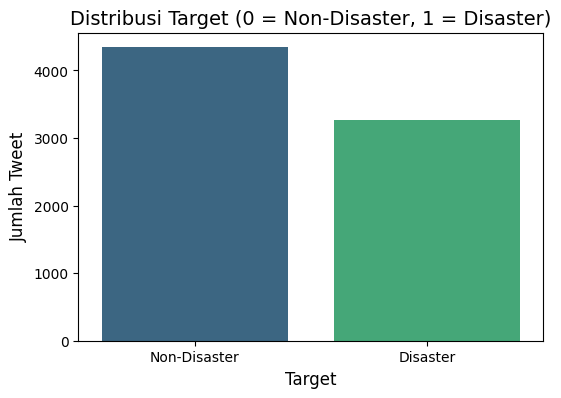

In [ ]:
# Memeriksa distribusi variabel 'target'
target_distribution = train_df['target'].value_counts()

# Visualisasi distribusi variabel 'target'
plt.figure(figsize=(6, 4))
sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')
plt.title('Distribusi Target (0 = Non-Disaster, 1 = Disaster)', fontsize=14)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)
plt.xticks([0, 1], labels=['Non-Disaster', 'Disaster'], fontsize=10)
plt.show()

Berdasarkan plot di atas, terlihat bahwa pada kolom 'target', label 0 memiliki jumlah yang lebih banyak dibandingkan dengan label 1. Dengan kata lain, non-disaster tweets lebih banyak dibandingkan disaster tweets.

<ipython-input-9-76ed8d503400>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')


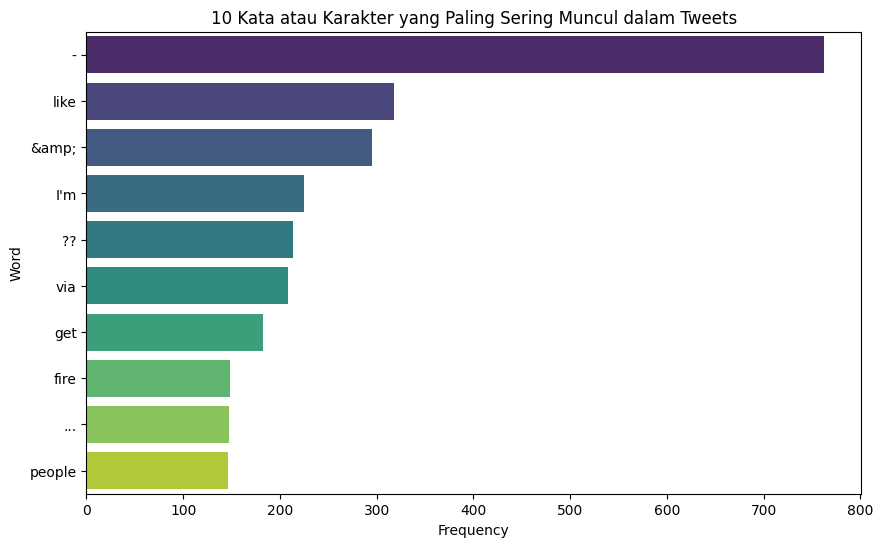

In [ ]:
# Kata-kata atau karakter yang paling sering muncul
stop_words = set(stopwords.words('english'))
all_text = " ".join(train_df['text'])
words = [word for word in all_text.split() if word.lower() not in stop_words]
word_freq = Counter(words)
common_words = word_freq.most_common(10)

# Visualisasi kata-kata atau karakter yang paling sering muncul
common_words_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')
plt.title('10 Kata atau Karakter yang Paling Sering Muncul dalam Tweets')
plt.show()

Plot di atas menunjukkan 10 kata dan karakter yang paling sering muncul dalam tweets.

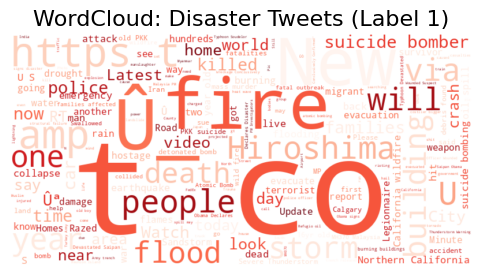

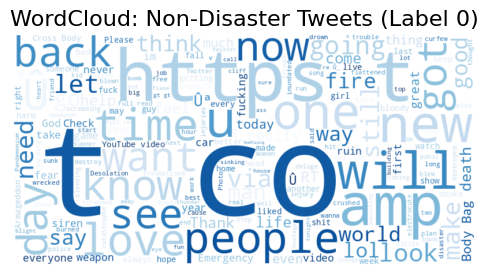

In [ ]:
# Generate WordCloud untuk disaster dan non-disaster tweets
disaster_text = " ".join(train_df[train_df['target'] == 1]['text'])
non_disaster_text = " ".join(train_df[train_df['target'] == 0]['text'])

# WordCloud untuk disaster tweets
plt.figure(figsize=(6, 3))
wc_disaster = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(disaster_text)
plt.imshow(wc_disaster, interpolation='bilinear')
plt.title('WordCloud: Disaster Tweets (Label 1)', fontsize=16)
plt.axis('off')
plt.show()

# WordCloud untuk non-disaster tweets
plt.figure(figsize=(6, 3))
wc_non_disaster = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(non_disaster_text)
plt.imshow(wc_non_disaster, interpolation='bilinear')
plt.title('WordCloud: Non-Disaster Tweets (Label 0)', fontsize=16)
plt.axis('off')
plt.show()

Kata-kata yang besar dan menonjol pada plot di atas menunjukkan kata yang paling sering muncul dalam tweets untuk masing-masing non-disaster tweets maupun disaster tweets. Sementara itu, kata-kata lainnya yang lebih kecil menunjukkan kata yang kurang dominan dalam masing-masing tweets tersebut.

# Text Processing

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Pre-processing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Tokenization and lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Tokenize using split and apply lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text

# Apply preprocessing to text columns
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)


1. Mengubah teks menjadi huruf kecil (lowercase):
Untuk memastikan konsistensi dalam data, karena huruf besar dan kecil dianggap berbeda oleh model. Contoh: "Earthquake" dan "earthquake" dianggap sama setelah diubah ke lowercase.

2. Menghapus URL: URL sering tidak relevan untuk analisis teks, sehingga perlu dihapus.

3. Karakter seperti #, @, angka, dan tanda baca biasanya tidak memberikan informasi bermakna untuk analisis teks.

4. Tokenisasi (Tokenization): Tokenisasi memecah teks menjadi kata-kata individu (token). Hal ini penting untuk memproses teks lebih lanjut, seperti penghapusan stopword atau lemmatization.

5. Menghapus kata-kata umum (Stopwords):
Stopwords adalah kata-kata umum seperti "the", "is", "and" yang sering muncul tetapi tidak membawa banyak makna. Menghapusnya membantu model fokus pada kata-kata yang lebih relevan.

6.  Lemmatization mengubah kata-kata menjadi bentuk dasarnya. Contohnya, "running" menjadi "run", atau "better" menjadi "good". Ini membantu menyederhanakan data dan mengurangi redundansi.

7. Menggabungkan kata kembali (Rejoin tokens):
Setelah proses seperti tokenisasi, penghapusan stopwords, dan lemmatization, perlu menggabungkan kata-kata kembali menjadi string agar dapat digunakan dalam model machine learning atau deep learning.

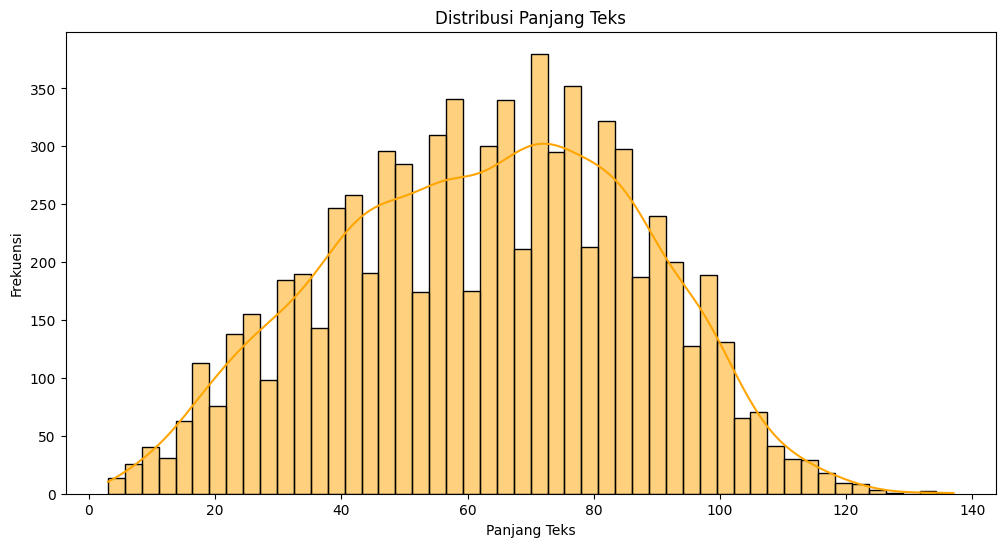

In [ ]:
# Cek panjang teks sebelum dan sesudah pembersihan
train_df['text_length'] = train_df['cleaned_text'].apply(len)
test_df['text_length'] = test_df['cleaned_text'].apply(len)

# Plot distribusi panjang teks
plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], kde=True, color='orange', bins=50)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.show()


Bentuk Distribusi:
Distribusi panjang teks terlihat menyerupai distribusi normal dengan puncak di sekitar panjang 60-70 karakter setelah dilakukan pembersihan.

Karakteristik Teks:
Ada beberapa teks yang sangat pendek (kurang dari 20 karakter), tetapi jumlahnya kecil.
Teks yang sangat panjang (lebih dari 120 karakter) juga relatif jarang ditemukan.


In [ ]:
#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization of text using TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # 1-gram, 2-gram features
X = tfidf.fit_transform(train_df['cleaned_text'])
X_test = tfidf.transform(test_df['cleaned_text'])
y = train_df['target']


In [ ]:
from sklearn.model_selection import train_test_split

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Extraction:
TF-IDF mengubah teks menjadi representasi numerik, sehingga model machine learning dapat memahami pola dalam data teks.
Dengan ngram_range=(1, 2), model bisa menangkap konteks kata-kata tunggal (unigram) maupun kombinasi kata (bigram).

Split Data:
Membagi data menjadi pelatihan dan validasi untuk mengevaluasi performa model dengan data yang belum pernah dilihat selama pelatihan

# Modelling

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)

    # Store results
    accuracy = accuracy_score(y_val, predictions)
    results[name] = accuracy

    # Print classification report
    print(f"Accuracy for {name}: {accuracy:.4f}")
    print(classification_report(y_val, predictions))

# Identify the best model based on accuracy
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")


Training Logistic Regression...
Accuracy for Logistic Regression: 0.8004
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Training Random Forest...
Accuracy for Random Forest: 0.7853
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       874
           1       0.80      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.79      0.78      1523

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:53:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for XGBoost: 0.7676
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       874
           1       0.79      0.62      0.69       649

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.75      1523
weighted avg       0.77      0.77      0.76      1523

Training Support Vector Machine...
Accuracy for Support Vector Machine: 0.7873
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       874
           1       0.78      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Best model: Logistic Regression


Interpretasi Performa Model berdasarkan Classification Report :


1.   **Model Regresi Logistik**
*   **Akurasi = 0.8** : Model berhasil memprediksi sebesar 80% dari total atau keseluruhan tweet. Terdapat 80% tweet yang benar diprediksi tentang bencana dan bukan bencana dari kesuluruhan tweet.
*  **Precision Target = 0 bernilai 0.79** : Terdapat 79% tweet yang benar memprediksi bukan bencana dari keseluruhan tweet yang diprediksi bukan tentang bencana.
*   **Precision 1 bernilai 0.82** : Terdapat 82% tweet yang benar memprediksi tentang bencana dari keseluruhan tweet yang diprediksi tentang bencana.
*   **Recall 0 bernilai 0.89** : Model ini berhasil mengidentifikasi 89% dari semua tweet yang aktualnya bukan tentang bencana.
*   **Recall 1 bernilai 0.67** : Model ini berhasil mengidentifikasi 67% dari semua tweet yang aktualnya tentang bencana.


2.   **Model Random Forest**
*   **Akurasi = 0.78** : Model berhasil memprediksi sebesar 78% dari total atau keseluruhan tweet. Terdapat 78% tweet yang benar diprediksi tentang bencana dan bukan bencana dari kesuluruhan tweet.
*   **Precision Target = 0 bernilai 0.77** : Terdapat 77% tweet yang benar memprediksi bukan bencana dari keseluruhan tweet yang diprediksi bukan tentang bencana.
*   **Precision 1 bernilai 0.78** : Terdapat 78% tweet yang benar memprediksi tentang bencana dari keseluruhan tweet yang diprediksi tentang bencana.
*   **Recall 0 bernilai 0.87** : Model ini berhasil mengidentifikasi 87% dari semua tweet yang aktualnya bukan tentang bencana.
*   **Recall 1 bernilai 0.65** : Model ini berhasil mengidentifikasi 65% dari semua tweet yang aktualnya tentang bencana.


3.   **Model XGBoost**
*   **Akurasi = 0.78** : Model berhasil memprediksi sebesar 78% dari total atau keseluruhan tweet. Terdapat 78% tweet yang benar diprediksi tentang bencana dan bukan bencana dari kesuluruhan tweet.
*   **Precision Target = 0 bernilai 0.76** : Terdapat 76% tweet yang benar memprediksi bukan bencana dari keseluruhan tweet yang diprediksi bukan tentang bencana.
*   **Precision 1 bernilai 0.8** : Terdapat 80% tweet yang benar memprediksi tentang bencana dari keseluruhan tweet yang diprediksi tentang bencana.
*   **Recall 0 bernilai 0.88** : Model ini berhasil mengidentifikasi 88% dari semua tweet yang aktualnya bukan tentang bencana.
*   **Recall 1 bernilai 0.63** : Model ini berhasil mengidentifikasi 63% dari semua tweet yang aktualnya tentang bencana.


4.   **Model SVC (Support Vector Machines)**
*   **Akurasi = 0.79** : Model berhasil memprediksi sebesar 79% dari total atau keseluruhan tweet. Terdapat 80% tweet yang benar diprediksi tentang bencana dan bukan bencana dari kesuluruhan tweet.
*   **Precision Target = 0 bernilai 0.79** : Terdapat 79% tweet yang benar memprediksi bukan bencana dari keseluruhan tweet yang diprediksi bukan tentang bencana.
*   **Precision 1 bernilai 0.79** : Terdapat 79% tweet yang benar memprediksi tentang bencana dari keseluruhan tweet yang diprediksi tentang bencana.
*   **Recall 0 bernilai 0.86** : Model ini berhasil mengidentifikasi 86% dari semua tweet yang aktualnya bukan tentang bencana.
*   **Recall 1 bernilai 0.7** : Model ini berhasil mengidentifikasi 70% dari semua tweet yang aktualnya tentang bencana.


**Support 0 sebanyak 874** : Ada sebanyak 874 sampel yang merupakan tweet bukan tentang bencana dari total 1523 sampel.
*   **Support 1 sebanyak 649** : Ada sebanyak 649 sampel yang merupakan tweet bukan tentang bencana dari total 1523 sampel.

**Berdasarkan performa model dalam memprediksi tweet bencana atau bukan, model regresi logistik menjadi model terbaik dibandingkan ketiga model lainnya yaitu, Random Forest, XGBoost, dan SVC.**

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid for tuning
param_grid = {
    'logistic regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    },
    'random forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    },
    'xgboost': {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'n_estimators': [100, 200]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

# Choose the best model and apply GridSearchCV
if best_model_name == 'Logistic Regression':
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid['logistic regression'], cv=3)
elif best_model_name == 'Random Forest':
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid['random forest'], cv=3)
elif best_model_name == 'XGBoost':
    grid_search = GridSearchCV(XGBClassifier(), param_grid['xgboost'], cv=3)
elif best_model_name == 'Support Vector Machine':
    grid_search = GridSearchCV(SVC(probability=True), param_grid['svm'], cv=3)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)
print(f"Best Parameters for {best_model_name}: {grid_search.best_params_}")


Best Parameters for Logistic Regression: {'C': 1, 'solver': 'liblinear'}


Kode di atas menunjukkan proses *hyperparameter tuning* menggunakan GridSearchCV. Hasil menunjukkan bahwa model terbaik setelah dilakukan  *tuning* adalah Regresi Logistik dengan parameter C = 1 dan menggunakan kernel *linear*.

In [ ]:
# Predict with the best model
final_predictions = best_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

# Save submission file
submission.to_csv('submission(13).csv', index=False)
print("Submission file 'submission(13).csv' generated!")


Submission file 'submission(13).csv' generated!


Memasukkan hasil prediksi ke dalam Dataframe baru

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation for the best model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy for {best_model_name}: {cv_scores.mean():.4f}")


Cross-Validation Accuracy for Logistic Regression: 0.6964


**Cross-Validation Accuracy for Logistic Regression =  0.6975** : Nilai ini menunjukkan bahwa model Logistic Regression memiliki tingkat prediksi yang benar dengan akurasi 69,75%

# Ensemble Model

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Create a voting classifier without XGBoost
voting_clf = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=200)),
    ('svc', SVC(kernel='linear', probability=True))
], voting='hard')

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate the Voting Classifier
voting_predictions = voting_clf.predict(X_val)
print(f"Voting Classifier Accuracy: {accuracy_score(y_val, voting_predictions):.4f}")


Voting Classifier Accuracy: 0.7951


**Voting Classifier Accuracy = 0.7945** : Ensemle Learning dengan metode Voting Clasifier yang terdiri dari Log Regression, Random Forest, dan SVC memiliki nilai akurasi sebesar 79,45%

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Create a stacking classifier using different base models
stacking_clf = StackingClassifier(
    estimators=[
        ('logreg', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(n_estimators=200)),
        ('svc', SVC(kernel='linear', probability=True))
    ],
    final_estimator=LogisticRegression()
)

# Train the Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Predict and evaluate the Stacking Classifier
stacking_predictions = stacking_clf.predict(X_val)
print(f"Stacking Classifier Accuracy: {accuracy_score(y_val, stacking_predictions):.4f}")


Stacking Classifier Accuracy: 0.7965


**Stacking Classifier Accuracy =  0.7971** : Ensemble Learning dengan metode Stacking Clasifier, yaitu dengan menggabungkan beberapa base model (Log Regression, Random Forest, dan SVC) dan menggunakan model meta (Log Regression) untuk prediksi akhir. Ensemble ini memiliki keakuratan prediksi sebesar 79,71%

# Kesimpulan
- Ensemble Learning dengan metode Stacking Classifier lebih baik daripada metode Voting Classifier dengan peningkatan akurasi sebesar 0,26% menunjukkan bahwa Stacking Classifier memberikan hasil yang lebih optimal meskipun tidak signifikan.